In [ ]:
zip_path = '/content/drive/My Drive/Colab Notebooks/x_train.zip'
!cp "{zip_path}" . 
!unzip -q x_train.zip
!rm x_train.zip

In [ ]:
zip_path = '/content/drive/My Drive/Colab Notebooks/y_train.zip'
!cp "{zip_path}" . 
!unzip -q y_train.zip
!rm y_train.zip

In [ ]:
zip_path = '/content/drive/My Drive/Colab Notebooks/x_test.zip'
!cp "{zip_path}" . 
!unzip -q x_test.zip
!rm x_test.zip

In [ ]:
zip_path = '/content/drive/My Drive/Colab Notebooks/x_val.zip'
!cp "{zip_path}" . 
!unzip -q x_val.zip
!rm x_val.zip

In [ ]:
zip_path = '/content/drive/My Drive/Colab Notebooks/y_val.zip'
!cp "{zip_path}" . 
!unzip -q y_val.zip
!rm y_val.zip

In [ ]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm
from tensorflow.keras.callbacks import TensorBoard
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import  gray2rgb, rgb2gray
import matplotlib.pyplot as plt

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

X_TRAIN_PATH = '/content/x_train/'
Y_TRAIN_PATH = '/content/y_train/'
X_TEST_PATH = '/content/x_test/'
X_VAL_PATH = '/content/x_val/'
Y_VAL_PATH = '/content/y_val/'

seed=42
random.seed = seed
np.random.seed = seed

import os 
train_ids = next( os.walk( X_TRAIN_PATH ) )[2]
test_ids = next( os.walk( X_TEST_PATH ) )[2]
val_ids = next( os.walk( X_VAL_PATH ) )[2]
print( "Length of Trains ids" , len( train_ids ) )
print( "Length of Test ids  ", len( test_ids ) )
print( "Length of Val ids  ", len( val_ids ) )

Length of Trains ids 28280
Length of Test ids   5000
Length of Val ids   5000


In [ ]:
X_train = np.zeros( (len( train_ids ), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8 )
Y_train = np.zeros( (len( train_ids ), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool )
X_val= np.zeros( (len( val_ids ), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8 )
Y_val= np.zeros( (len( val_ids ), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool )
synt = np.zeros ( (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8 )

In [ ]:
print( 'Resizing training images' )
for n, id_ in tqdm( enumerate( train_ids ), total=len( train_ids ) ):
    img = imread( X_TRAIN_PATH + id_ )
    img = resize( img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True )
    if img.shape != synt.shape :
        img = gray2rgb(img)
    X_train[n] = img
    img2 = imread( Y_TRAIN_PATH + id_[:7] + '.png')
    img2 = resize( img2, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True )
    for i in range(128):
        for j in range(128):
            for k in range(3):
                if img2[i,j,k]>0 :
                    img2[i,j,0]=255
                    img2[i,j,1]=255
                    img2[i,j,2]=255
    img2=rgb2gray(img2)
    img2 = img2[:, :, np.newaxis]
    Y_train[n] = img2

  0%|          | 1/28280 [00:00<1:26:00,  5.48it/s]

Resizing training images


100%|██████████| 28280/28280 [1:05:50<00:00,  7.16it/s]


In [ ]:
print( 'Resizing Validation images' )
for n, id_ in tqdm( enumerate( val_ids ), total=len( val_ids ) ):
    img = imread( X_VAL_PATH + id_ )
    img = resize( img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True )
    if img.shape != synt.shape :
        img = gray2rgb(img)
    X_val[n] = img
    img2 = imread( Y_VAL_PATH + id_[:7] + '.png')
    img2 = resize( img2, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True )
    for i in range(128):
        for j in range(128):
            for k in range(3):
                if img2[i,j,k]>0 :
                    img2[i,j,0]=255
                    img2[i,j,1]=255
                    img2[i,j,2]=255
    img2=rgb2gray(img2)
    img2 = img2[:, :, np.newaxis]
    Y_val[n] = img2

  0%|          | 1/5000 [00:00<08:43,  9.55it/s]

Resizing Validation images


100%|██████████| 5000/5000 [11:39<00:00,  7.15it/s]


In [ ]:
X_test = np.zeros( (len( test_ids ), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8 )
print( 'Resizing test images' )
for n, id_ in tqdm( enumerate( test_ids ), total=len( test_ids ) ):
    img3 = imread( X_TEST_PATH + id_ )
    img3 = resize( img3, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True )
    if img3.shape != synt.shape :
        img3 = img3[:, :, np.newaxis]
    X_test[n] = img3


print( 'Data Pre-processing Done' )

  0%|          | 6/5000 [00:00<01:55, 43.16it/s]

Resizing test images


100%|██████████| 5000/5000 [02:19<00:00, 35.83it/s]

Data Pre-processing Done


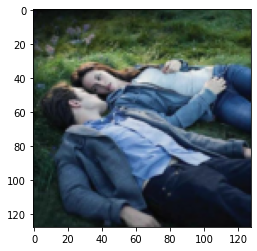

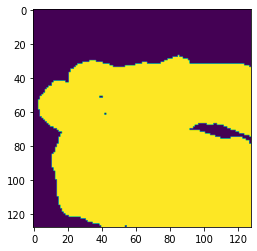

In [ ]:
image_x = random.randint(0, len(train_ids))
plt.imshow(X_train[image_x])
plt.show()
plt.imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [ ]:
image_size=128
# Build the model
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = tf.keras.layers.UpSampling2D((2, 2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [ ]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = tf.keras.layers.Input( (image_size, image_size, 3) )

    p0 = inputs
    c1, p1 = down_block( p0, f[0] )  # 128 -> 64
    c2, p2 = down_block( p1, f[1] )  # 64 -> 32
    c3, p3 = down_block( p2, f[2] )  # 32 -> 16
    c4, p4 = down_block( p3, f[3] )  # 16->8

    bn = bottleneck( p4, f[4] )

    u1 = up_block( bn, c4, f[3] )  # 8 -> 16
    u2 = up_block( u1, c3, f[2] )  # 16 -> 32
    u3 = up_block( u2, c2, f[1] )  # 32 -> 64
    u4 = up_block( u3, c1, f[0] )  # 64 -> 128

    outputs = tf.keras.layers.Conv2D( 1, (1, 1), padding="same", activation="sigmoid" )( u4 )
    model = tf.keras.models.Model( inputs, outputs )
    return model


In [ ]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
tensorboard_callback = TensorBoard(log_dir='./logs')
results = model.fit(X_train, Y_train,validation_data=(X_val,Y_val), batch_size=16, epochs=50, callbacks=[tensorboard_callback])
val_loss,val_accuracy = model.evaluate(X_val, Y_val)
print(val_loss,val_accuracy*100)

model.save("model_unet.h5")


Epoch 1/50
1768/1768 [==============================] - 237s 134ms/step - loss: 0.4292 - mean_io_u: 0.2805 - val_loss: 0.3287 - val_mean_io_u: 0.2842
Epoch 2/50
1768/1768 [==============================] - 235s 133ms/step - loss: 0.3129 - mean_io_u: 0.2804 - val_loss: 0.2831 - val_mean_io_u: 0.2842
Epoch 3/50
1768/1768 [==============================] - 235s 133ms/step - loss: 0.2818 - mean_io_u: 0.2805 - val_loss: 0.2904 - val_mean_io_u: 0.2842
Epoch 4/50
1768/1768 [==============================] - 235s 133ms/step - loss: 0.2625 - mean_io_u: 0.2807 - val_loss: 0.2607 - val_mean_io_u: 0.2855
Epoch 5/50
1768/1768 [==============================] - 235s 133ms/step - loss: 0.2494 - mean_io_u: 0.2809 - val_loss: 0.2582 - val_mean_io_u: 0.2849
Epoch 6/50
1768/1768 [==============================] - 235s 133ms/step - loss: 0.2406 - mean_io_u: 0.2808 - val_loss: 0.2502 - val_mean_io_u: 0.2844
Epoch 7/50
1768/1768 [==============================] - 235s 133ms/step - loss: 0.2327 - mean_io_u: 

In [ ]:
preds_train = model.predict( X_train, verbose=1 )
preds_val = model.predict( X_val, verbose=1 )
preds_test = model.predict( X_test, verbose=1 )
preds_train_t = (preds_train > 0.5).astype( np.uint8 )
preds_val_t = (preds_val > 0.5).astype( np.uint8 )
preds_test_t = (preds_test > 0.5).astype( np.uint8 )


157/157 [==============================] - 12s 75ms/step


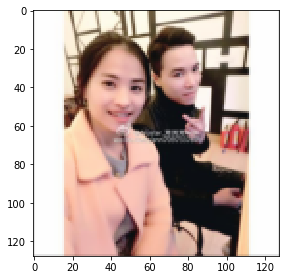

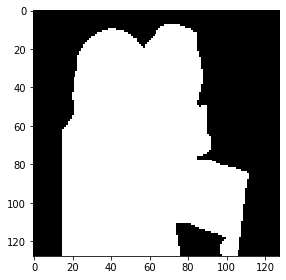

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


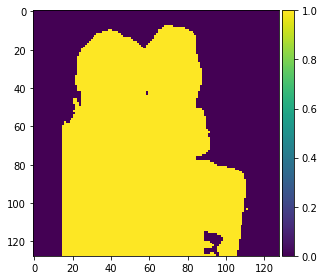

In [ ]:
ix1 = random.randint(0, len(preds_train_t))
imshow(X_train[ix1])
plt.show()
imshow(np.squeeze(Y_train[ix1]))
plt.show()
imshow(np.squeeze(preds_train_t[ix1]))
plt.show()

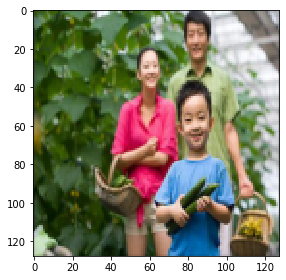

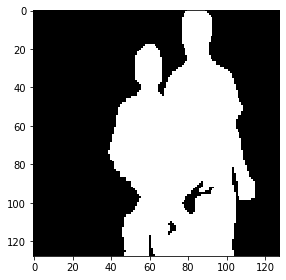

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


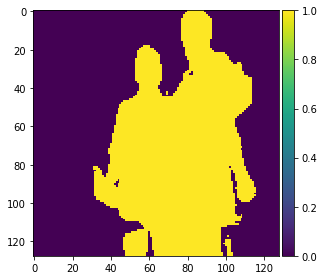

In [ ]:
ix2 = random.randint(0, len(preds_val_t))
imshow(X_val[ix2])
plt.show()
imshow(np.squeeze(Y_val[ix2]))
plt.show()
imshow(np.squeeze(preds_val_t[ix2]))
plt.show()

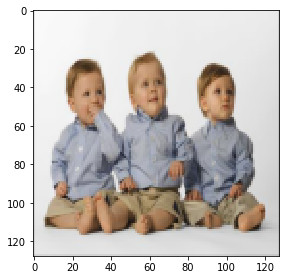

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


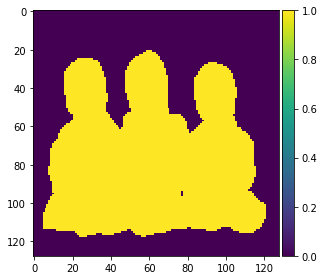

In [ ]:
ix3 = random.randint(0, len(preds_test_t))
imshow(X_test[ix3])
plt.show()
imshow(np.squeeze(preds_test_t[ix3]))
plt.show()